In [1]:
# pip install numpy==1.19.2

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [3]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [4]:
tf.random.set_seed(12345)

In [5]:
# pip install -U numpy==1.18.5

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [7]:
f = h5py.File("mercado_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [8]:
scaled_X

masked_array(
  data=[[0.3028322440087146],
        [0.30718954248366015],
        [0.2984749455337691],
        [0.2701525054466231],
        [0.2962962962962963],
        [0.27450980392156865],
        [0.2505446623093682],
        [0.2505446623093682],
        [0.23965141612200436],
        [0.21350762527233116],
        [0.20043572984749455],
        [0.19825708061002179],
        [0.18736383442265794],
        [0.224400871459695],
        [0.20261437908496735],
        [0.18300653594771243],
        [0.1917211328976035],
        [0.20043572984749455],
        [0.21132897603485837],
        [0.21350762527233116],
        [0.20043572984749455],
        [0.2222222222222222],
        [0.22657952069716777],
        [0.23093681917211328],
        [0.22875816993464054],
        [0.25272331154684097],
        [0.2222222222222222],
        [0.20043572984749455],
        [0.19389978213507628],
        [0.2047930283224401],
        [0.224400871459695],
        [0.23965141612200436],
        

In [9]:
scaled_X.shape

(38076, 1)

In [10]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

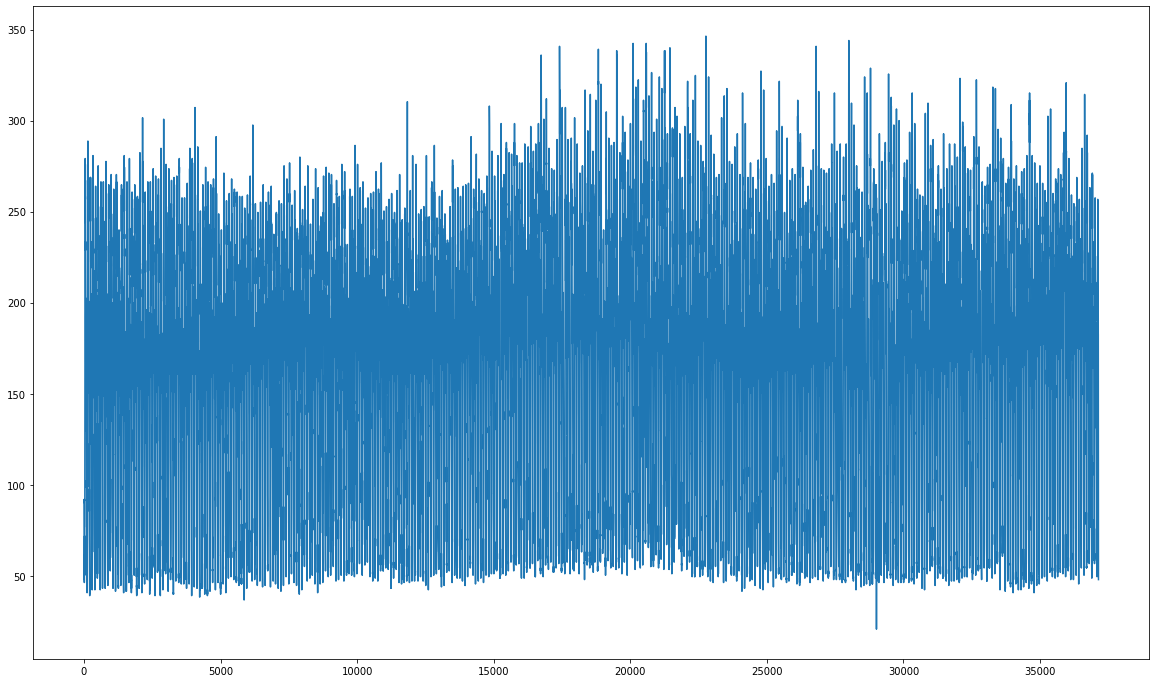

In [11]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [12]:
def partitionSet(test_fraction, data, partition):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partition/100)*lenX):int((partition/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partition/100)*lenX)-1],data[int((partition/100)*lenX)+test_size:]))
    train_df[int((partition/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

[train_df,test_df] = partitionSet(0.25,scaled_X, 8)

In [13]:
timesteps = 48

In [14]:
X_train = ma.array([train_df[t:t+timesteps] for t in range(0, len(train_df)-timesteps)])
y_train = train_df[timesteps:, :]
X_test = ma.array([test_df[t:t+timesteps] for t in range(0, len(test_df)-timesteps)]) 
y_test = test_df[timesteps:, :]

In [15]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = Adam(learning_rate = 0.00004)
    model.compile(loss = 'mse', optimizer=opt)
    X_ = ma.filled(X_train,0)
    Y_ = ma.filled(y_train,0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False)
    return model, MODEL

In [16]:
model, MODEL = LSTM_function(64, X_train.shape[1], 1, 0.2, 200, 256, 0.2)

Epoch 1/200
90/90 [==============================] - 16s 72ms/step - loss: 0.2064 - val_loss: 0.1369
Epoch 2/200
90/90 [==============================] - 3s 37ms/step - loss: 0.1059 - val_loss: 0.0423
Epoch 3/200
90/90 [==============================] - 3s 38ms/step - loss: 0.0444 - val_loss: 0.0345
Epoch 4/200
90/90 [==============================] - 4s 41ms/step - loss: 0.0439 - val_loss: 0.0342
Epoch 5/200
90/90 [==============================] - 4s 46ms/step - loss: 0.0433 - val_loss: 0.0339
Epoch 6/200
90/90 [==============================] - 4s 44ms/step - loss: 0.0428 - val_loss: 0.0336
Epoch 7/200
90/90 [==============================] - 4s 46ms/step - loss: 0.0426 - val_loss: 0.0334
Epoch 8/200
90/90 [==============================] - 4s 47ms/step - loss: 0.0421 - val_loss: 0.0332
Epoch 9/200
90/90 [==============================] - 4s 47ms/step - loss: 0.0417 - val_loss: 0.0329
Epoch 10/200
90/90 [==============================] - 4s 45ms/step - loss: 0.0409 - val_loss: 0.032

90/90 [==============================] - 3s 34ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 163/200
90/90 [==============================] - 4s 39ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 164/200
90/90 [==============================] - 4s 40ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 165/200
90/90 [==============================] - 4s 41ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 166/200
90/90 [==============================] - 4s 40ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 167/200
90/90 [==============================] - 3s 39ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 168/200
90/90 [==============================] - 3s 38ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 169/200
90/90 [==============================] - 3s 38ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 170/200
90/90 [==============================] - 4s 39ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 171/200
90/90 [==============================] - 4s 40ms/step - loss: 0.0075 - val_loss: 0

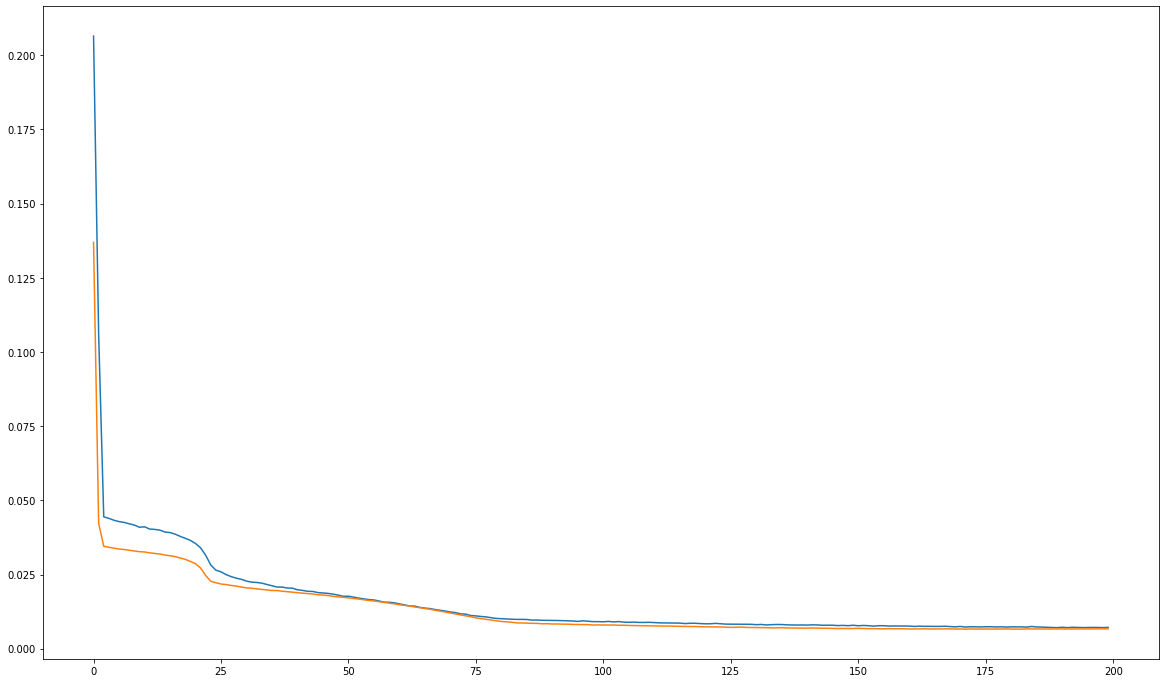

In [17]:
plt.plot(MODEL.history['loss'])
plt.plot(MODEL.history['val_loss'])
plt.show()

In [18]:
prediction_test = model.predict(X_test)

In [47]:
prediction_train = model.predict(X_train)

In [48]:
train_pred = ma.masked_invalid(prediction_train)

In [49]:
train_pred[train_pred==train_pred.min()] = ma.masked

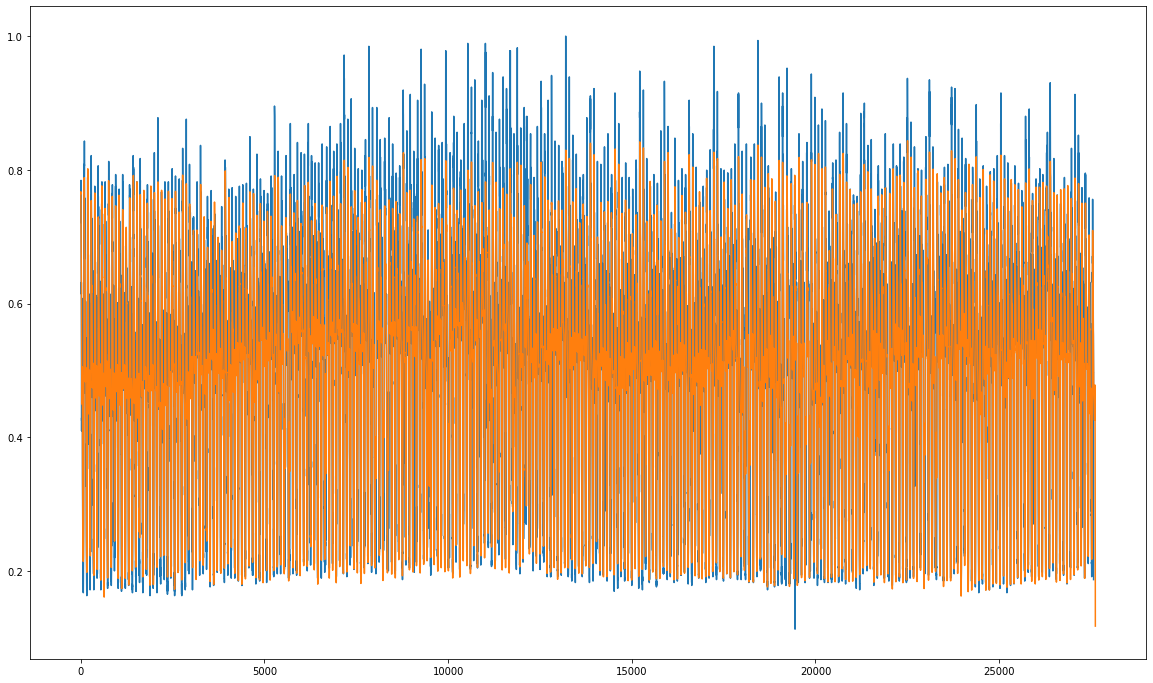

In [51]:
plt.plot(y_train[:,0])
plt.plot(train_pred)
plt.show()

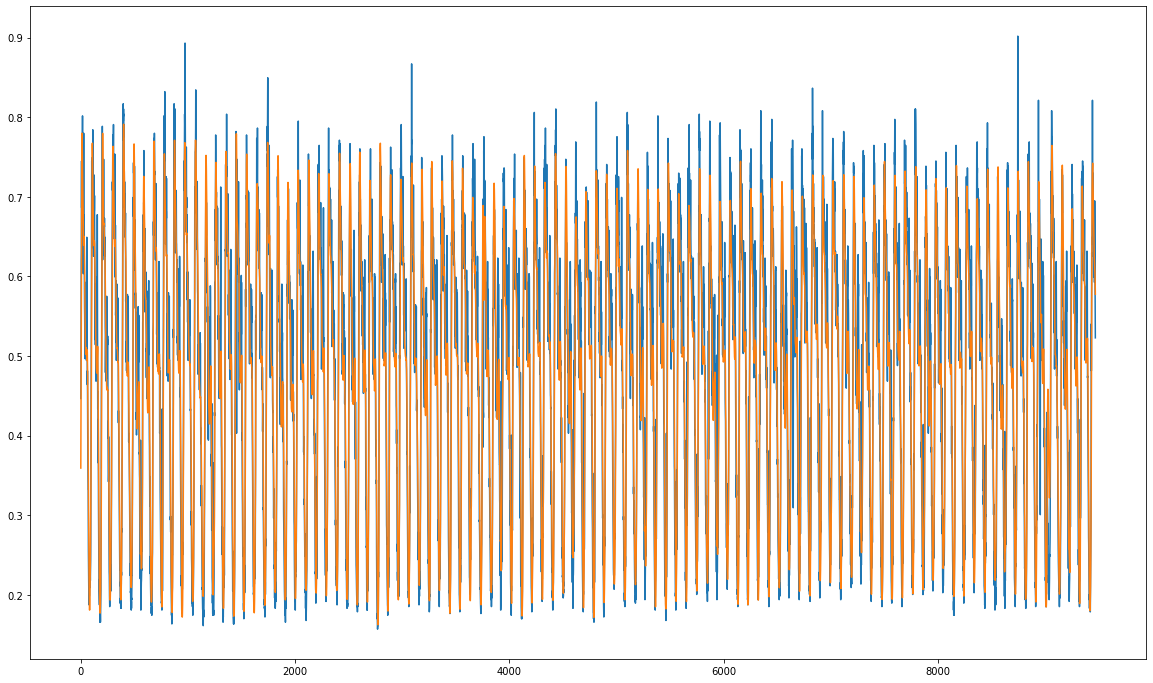

In [53]:
plt.plot(y_test[:,0])
plt.plot(prediction_test)
plt.show()

In [54]:
inputs = scaled_X[len(scaled_X) - len(test_df) - timesteps:]

In [55]:
inputs

masked_array(
  data=[[0.5076252723311547],
        [0.4814814814814815],
        [0.5010893246187365],
        [0.5010893246187365],
        [0.505446623093682],
        [0.4727668845315905],
        [0.4901960784313726],
        [0.49673202614379086],
        [0.5272331154684097],
        [0.5032679738562092],
        [0.5468409586056645],
        [0.5185185185185186],
        [0.542483660130719],
        [0.5533769063180829],
        [0.6034858387799565],
        [0.5403050108932462],
        [0.4705882352941177],
        [0.46405228758169936],
        [0.4139433551198257],
        [0.383442265795207],
        [0.36601307189542487],
        [0.36601307189542487],
        [0.35294117647058826],
        [0.34422657952069713],
        [0.3202614379084967],
        [0.3028322440087146],
        [0.2832244008714597],
        [0.2657952069716776],
        [0.2549019607843137],
        [0.25272331154684097],
        [0.23093681917211328],
        [0.23093681917211328],
        [0.215686274

In [56]:
inputs = inputs.reshape(-1,1)

In [57]:
X_test = []

In [58]:
for i in range(48, 720):
    X_test.append(inputs[i-timesteps:i,0])

In [59]:
X_test = np.array(X_test)

In [60]:
X_test.shape

(672, 48)

In [61]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [62]:
predicted_demand = model.predict(X_test)

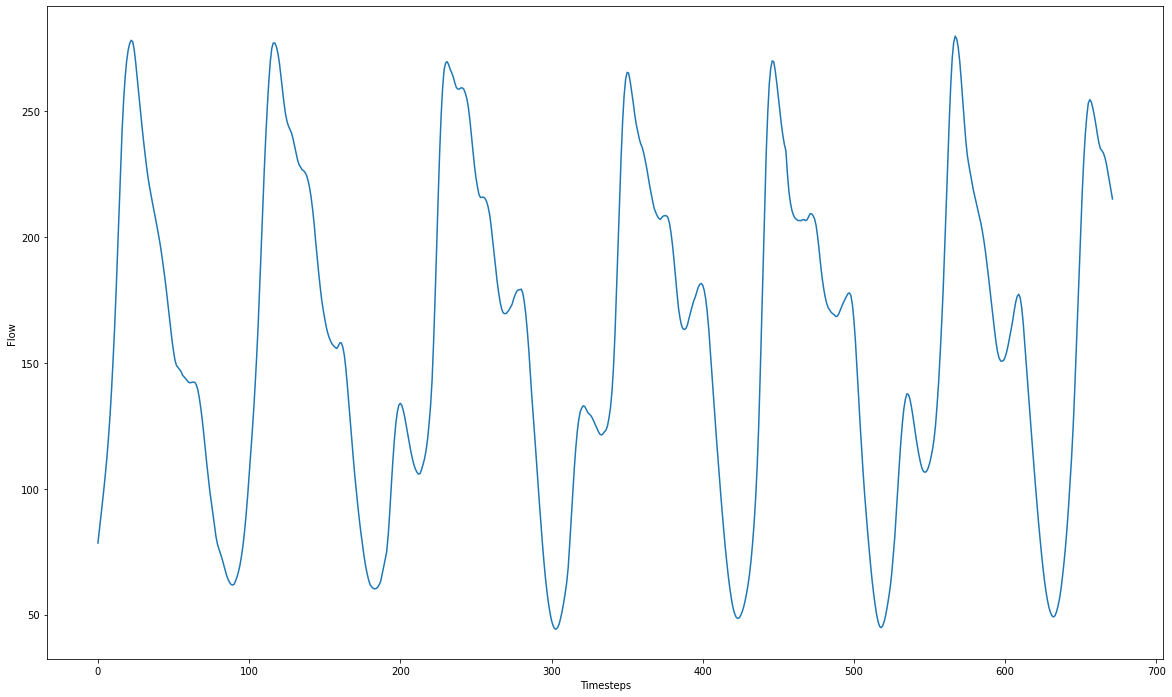

In [63]:
plt.plot(inverse_scaler(predicted_demand, minX, maxX))
plt.xlabel('Timesteps')
plt.ylabel('Flow')
plt.savefig('prediction.jpg')